In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearnex import patch_sklearn

patch_sklearn()

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from keras import regularizers
from keras.layers import Dense, Dropout
from keras.models import Sequential
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import (accuracy_score, f1_score, precision_score,
                             recall_score)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from keras.optimizers import RMSprop, Adam

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Detecção câncer de mama

### Importação

In [2]:
SELECTED_DATABASE = "mias"

try:
    breast_cancer_df = pd.read_csv(
        f"../../outputs/mamografia/{SELECTED_DATABASE}/first_order_features_{SELECTED_DATABASE}.csv"
    )
    aux = pd.read_csv(f"../../outputs/mamografia/{SELECTED_DATABASE}/glcm_features_{SELECTED_DATABASE}.csv")
    breast_cancer_df = pd.concat([breast_cancer_df.drop(columns='pathology'), aux], axis=1)
except FileNotFoundError:
    raise Exception("Database not found!")

breast_cancer_df.head()

,mean,std,smoothness,third_moment,uniformity,entropy,dissimilarity_dist_1_ang_0,dissimilarity_dist_1_ang_45,dissimilarity_dist_1_ang_90,dissimilarity_dist_1_ang_135,...,contrast_dist_1_ang_135,energy_dist_1_ang_0,energy_dist_1_ang_45,energy_dist_1_ang_90,energy_dist_1_ang_135,ASM_dist_1_ang_0,ASM_dist_1_ang_45,ASM_dist_1_ang_90,ASM_dist_1_ang_135,pathology
0,154.24557,51.805473,0.999628,-38705.156,0.005436,7.633350,4.625919,6.196418,5.005535,5.335784,...,52.560922,0.020599,0.017327,0.019312,0.018479,0.000424,0.000300,0.000373,0.000341,benign
1,187.77623,33.506527,0.999110,-8337.195,0.008888,6.943397,3.868332,4.704555,3.893180,4.551105,...,40.583774,0.031036,0.026001,0.028314,0.026572,0.000963,0.000676,0.000802,0.000706,benign
2,226.20087,20.717611,0.997676,-26923.965,0.029172,5.512225,2.808325,4.833903,3.721335,3.431363,...,37.676600,0.066008,0.053864,0.060593,0.063414,0.004357,0.002901,0.003672,0.004021,benign
3,226.20087,20.717611,0.997676,-26923.965,0.029172,5.512225,2.808325,4.833903,3.721335,3.431363,...,37.676600,0.066008,0.053864,0.060593,0.063414,0.004357,0.002901,0.003672,0.004021,benign
4,219.05660,28.411573,0.998763,-33156.960,0.020903,6.114886,4.324955,5.098914,4.809695,6.073281,...,100.520808,0.053347,0.049548,0.052149,0.047895,0.002846,0.002455,0.002720,0.002294,benign


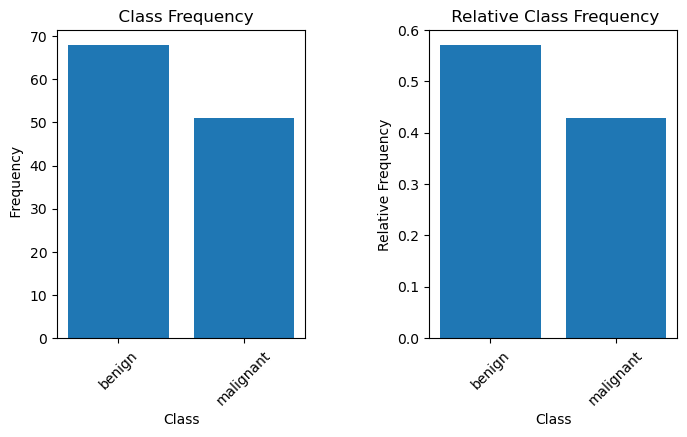

In [3]:
fig = plt.figure(figsize=(8, 4))
titles = ['', 'Relative']

for i, title in enumerate(titles, start=1):
    isRelative = True if i == 2 else False
    frequency = breast_cancer_df['pathology'].value_counts(normalize=isRelative)
    plt.subplot(1, 2, i)
    plt.bar(frequency.index, frequency)
    plt.title(f' {title} Class Frequency')
    plt.xlabel('Class'), plt.ylabel(f'{title} Frequency')
    plt.xticks(rotation=45)
fig.subplots_adjust(wspace=0.5)
plt.show()

### Pré-Processamento

In [4]:
# Elimina os dados com classe BENIGN_WITHOUT_CALLBACK ou NORMAL
breast_cancer_df = breast_cancer_df[breast_cancer_df["pathology"] != "benign_without_callback"]
breast_cancer_df = breast_cancer_df[breast_cancer_df["pathology"] != "normal"]

# Elimina os dados com valores nulos
breast_cancer_df.dropna(inplace=True)

# Separa em features e labels
X, y = (breast_cancer_df.drop(["pathology"], axis=1), breast_cancer_df["pathology"])

pca = PCA(n_components=11)
X_pca = pca.fit_transform(X)

# Tratamos os rótulos categóricos
y = y.map({"benign": 0, "malignant": 1})

# Separa os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.20)

# Balanceamento dos dados
if SELECTED_DATABASE in ["inbreast", "mias"]:
    smote = SMOTE()
    X_train, y_train = smote.fit_resample(X_train, y_train)
elif SELECTED_DATABASE == "cmmd":
    nearmiss = NearMiss(version=1)
    X_train, y_train = nearmiss.fit_resample(X_train, y_train)

# Padroniza os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Treinamento dos modelos

In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.20)
input_dim = X_train.shape[1]

""" epochs = [5, 7, 10, 12, 15, 20, 25, 30, 35, 40]
dropouts = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

best_config = None
best_score = 0

for epoch in epochs:
    for dropout1 in dropouts:
        for dropout2 in dropouts:
            model = Sequential()
            model.add(Dropout(dropout1, input_dim=input_dim))
            model.add(Dense(32, activation="relu"))
            model.add(Dropout(dropout2))
            model.add(Dense(1, activation="sigmoid"))

            model.compile(optimizer=RMSprop(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])
            model.fit(X_train, y_train, epochs=epoch, batch_size=16, verbose=0)

            y_train_pred = model.predict(X_train)
            y_train_pred = (y_train_pred > 0.5)
            y_pred = model.predict(X_valid)
            y_pred = (y_pred > 0.5)

            if accuracy_score(y_valid, y_pred) > best_score:
                best_score = accuracy_score(y_valid, y_pred)
                best_config = (epoch, dropout1, dropout2)

                print(f"Dropout1: {dropout1}")
                print(f"Dropout2: {dropout2}")
                print(f"Accuracy: {accuracy_score(y_valid, y_pred)}")
                print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred)}")
                print() """

' epochs = [5, 7, 10, 12, 15, 20, 25, 30, 35, 40]\ndropouts = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]\n\nbest_config = None\nbest_score = 0\n\nfor epoch in epochs:\n    for dropout1 in dropouts:\n        for dropout2 in dropouts:\n            model = Sequential()\n            model.add(Dropout(dropout1, input_dim=input_dim))\n            model.add(Dense(32, activation="relu"))\n            model.add(Dropout(dropout2))\n            model.add(Dense(1, activation="sigmoid"))\n\n            model.compile(optimizer=RMSprop(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])\n            model.fit(X_train, y_train, epochs=epoch, batch_size=16, verbose=0)\n\n            y_train_pred = model.predict(X_train)\n            y_train_pred = (y_train_pred > 0.5)\n            y_pred = model.predict(X_valid)\n            y_pred = (y_pred > 0.5)\n\n            if accuracy_score(y_valid, y_pred) > best_score:\n                best_score = accuracy_score(y_valid, y_pred)\n           

In [6]:
"""
# Melhor configuração encontrada
model = Sequential()
model.add(Dropout(dropout1, input_dim=input_dim))
model.add(Dense(32, activation="relu"))
model.add(Dropout(dropout2))
model.add(Dense(1, activation="sigmoid"))

Epochs = 7
BatchSize = 16
Neurons = 32
Dropout1 = 0.7
Dropout2 = 0.5
"""

'\n# Melhor configuração encontrada\nmodel = Sequential()\nmodel.add(Dropout(dropout1, input_dim=input_dim))\nmodel.add(Dense(32, activation="relu"))\nmodel.add(Dropout(dropout2))\nmodel.add(Dense(1, activation="sigmoid"))\n\nEpochs = 7\nBatchSize = 16\nNeurons = 32\nDropout1 = 0.7\nDropout2 = 0.5\n'

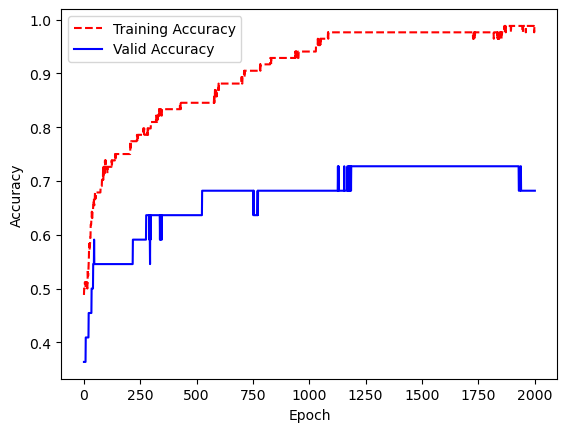

In [7]:
from keras.callbacks import EarlyStopping

epochs = 2000
batch_size = 16

def create_mlp_model(shape):
    model = Sequential()
    model.add(Dense(25, activation="relu", input_dim=shape))
    model.add(Dense(50, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer=RMSprop(learning_rate=0.0001), metrics=["accuracy"])
    return model

callbacks = [
    EarlyStopping(monitor="val_loss", patience=5),
]

model = create_mlp_model(input_dim)
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid),
                    epochs=epochs, batch_size=batch_size,
                    verbose=0)

# Get training and test loss histories
training_loss = history.history["accuracy"]
test_loss = history.history["val_accuracy"]
# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)
# Visualize loss history
plt.plot(epoch_count, training_loss, "r--")
plt.plot(epoch_count, test_loss, "b-")
plt.legend(["Training Accuracy", "Valid Accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()


In [8]:

random_forest_best_param = {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'entropy',
                            'max_depth': 20, 'max_features': 1.0, 'n_estimators': 20, 'oob_score': True}
random_forest_model = RandomForestClassifier(**random_forest_best_param)

gradient_boosting_best_param = {'learning_rate': 0.5, 'max_depth': 150, 'max_features': 1.0,
                                'n_estimators': 50, 'subsample': 0.9}
gradient_boosting_model = GradientBoostingClassifier(**gradient_boosting_best_param)

mlp_model = create_mlp_model(X_train.shape[1])

models = [random_forest_model, gradient_boosting_model]
titles = ['Random Forest', 'Gradient Boosting']

for model, title in zip(models, titles):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)

    train_accuracy = accuracy_score(y_train, y_train_pred)
    valid_accuracy = accuracy_score(y_valid, y_valid_pred)

    print(
        f"{title}:\n"
        f"Train Accuracy: {train_accuracy:.4f}\n"
        f"Valid Accuracy: {valid_accuracy:.4f}\n"
    )

mlp_model.fit(X_train, y_train, epochs=400, batch_size=batch_size, verbose=0)

y_train_pred = mlp_model.predict(X_train)
y_valid_pred = mlp_model.predict(X_valid)
y_train_pred = (y_train_pred > 0.5).astype(int)
y_valid_pred = (y_valid_pred > 0.5).astype(int)


train_accuracy = accuracy_score(y_train, y_train_pred)
valid_accuracy = accuracy_score(y_valid, y_valid_pred)

print(
    f"MLP:\n"
    f"Train Accuracy: {train_accuracy:.4f}\n"
    f"Valid Accuracy: {valid_accuracy:.4f}\n"
)

Random Forest:
Train Accuracy: 0.9881
Valid Accuracy: 0.6364

Gradient Boosting:
Train Accuracy: 0.9881
Valid Accuracy: 0.7273

1/1 [==============================] - 0s 22ms/step
MLP:
Train Accuracy: 0.8690
Valid Accuracy: 0.6818



In [9]:
""" # Função para criar o modelo do Keras
def create_mlp_model(shape):
    model = Sequential()
    model.add(Dense(25, input_dim=shape, activation="relu"))
    model.add(Dense(50, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
    return model


# Models
random_forest_best_param = {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'entropy',
                            'max_depth': 20, 'max_features': 1.0, 'n_estimators': 20, 'oob_score': True}
random_forest_model = RandomForestClassifier(**random_forest_best_param)

boosted_tree_best_param = {'learning_rate': 0.5, 'max_depth': 150, 'max_features': 1.0,
                                'n_estimators': 50, 'subsample': 0.9}
boosted_tree_model = GradientBoostingClassifier(**boosted_tree_best_param)

mlp_model = create_mlp_model(X_train.shape[1])

threshold = 0.5
titles = ["Random Forest", "Boosted Tree", "MLP"]
models = [random_forest_model, boosted_tree_model, mlp_model]
scores = {}

for model, title in zip(models, titles):
    predict = []
    if title == "MLP":
        model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=0)
        predict = model.predict(X_test)
        predict = (predict > threshold).astype(int) # Transformar as saídas em rótulos
    else:
        model.fit(X_train, y_train)
        predict = model.predict(X_test)

    scores[title] = {"accuracy_score": accuracy_score(y_test, predict) * 100}
    scores[title]["precision_score"] = precision_score(y_test, predict) * 100
    scores[title]["recall_score"] = recall_score(y_test, predict) * 100
    scores[title]["f1_score"] = f1_score(y_test, predict) * 100 """

' # Função para criar o modelo do Keras\ndef create_mlp_model(shape):\n    model = Sequential()\n    model.add(Dense(25, input_dim=shape, activation="relu"))\n    model.add(Dense(50, activation="relu"))\n    model.add(Dense(1, activation="sigmoid"))\n    model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])\n    return model\n\n\n# Models\nrandom_forest_best_param = {\'bootstrap\': True, \'class_weight\': \'balanced\', \'criterion\': \'entropy\',\n                            \'max_depth\': 20, \'max_features\': 1.0, \'n_estimators\': 20, \'oob_score\': True}\nrandom_forest_model = RandomForestClassifier(**random_forest_best_param)\n\nboosted_tree_best_param = {\'learning_rate\': 0.5, \'max_depth\': 150, \'max_features\': 1.0,\n                                \'n_estimators\': 50, \'subsample\': 0.9}\nboosted_tree_model = GradientBoostingClassifier(**boosted_tree_best_param)\n\nmlp_model = create_mlp_model(X_train.shape[1])\n\nthreshold = 0.5\ntitles = ["R

### Avaliação dos modelos

In [10]:
#scores_df = pd.DataFrame(scores).T
#scores_df

In [11]:
""" result = [[66.66, 66.66, 66.66, 58.33], [50.00, 50.00, 54.16, 50.00], []]

columns=['Random Forest', 'Boosted Tree', 'MLP']
df = pd.DataFrame(result, columns=columns)

def mean_without_extremes(df):
    new_df = pd.DataFrame(columns=df.columns)
    for col in df.columns:
        df.sort_values(by=col, inplace=True)
        df[col] = df[col].drop(df[col].index[[0, -1]])
        new_df[col] = [df[col].mean()]
    return new_df

df = mean_without_extremes(df)
df """

" result = [[66.66, 66.66, 66.66, 58.33], [50.00, 50.00, 54.16, 50.00], []]\n\ncolumns=['Random Forest', 'Boosted Tree', 'MLP']\ndf = pd.DataFrame(result, columns=columns)\n\ndef mean_without_extremes(df):\n    new_df = pd.DataFrame(columns=df.columns)\n    for col in df.columns:\n        df.sort_values(by=col, inplace=True)\n        df[col] = df[col].drop(df[col].index[[0, -1]])\n        new_df[col] = [df[col].mean()]\n    return new_df\n\ndf = mean_without_extremes(df)\ndf "